In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from timm import create_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import StepLR

In [ ]:
# Install necessary libraries
#!pip install torch torchvision timm

# Import libraries
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,random_split
from torchvision import transforms, datasets
from tqdm import tqdm
import timm  # Library containing EfficientFormer models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
dataset_path = "/content/drive/MyDrive/images"

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale images to 3 channels
    transforms.Resize((224, 224)),                # Resize images to 224x224 for ConvNeXt
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],   # Standard normalization values
                         [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Print class names
class_names = full_dataset.classes
print("Classes:", class_names)


Using device: cuda
Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']


In [ ]:
# Initialize EfficientFormer model
model = timm.create_model('efficientformer_l1', pretrained=True, num_classes=4)  # Replace 'l1' with another variant if desired

# Send model to device
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/49.4M [00:00<?, ?B/s]

In [ ]:
# Training function
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    for inputs, labels in tqdm(loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        # Store predictions and labels for metrics calculation
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")
    return epoch_loss, epoch_acc, precision, recall, f1

# Validation function
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            # Store predictions and labels for metrics calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")
    return epoch_loss, epoch_acc,precision, recall, f1
# Tracking metrics for visualization
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
train_precisions, train_recalls, train_f1s = [], [], []
val_precisions, val_recalls, val_f1s = [], [], []

In [ ]:
import torch.optim as optim

# Hyperparameters
num_epochs = 10
learning_rate = 1e-4
weight_decay = 1e-5

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Training
    train_loss, train_acc, train_precision, train_recall, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion)
    print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}%, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1 Score: {train_f1:.2f}")

    # Validation
    val_loss, val_acc, val_precision, val_recall, val_f1 = validate(model, val_loader, criterion)
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc*100:.2f}%, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1 Score: {val_f1:.2f}\n")
    # Store metrics for visualization
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)


Epoch 1/10


Training: 100%|██████████| 312/312 [24:35<00:00,  4.73s/it]


Training Loss: 0.1614, Accuracy: 94.63%, Precision: 0.95, Recall: 0.95, F1 Score: 0.95


Validation: 100%|██████████| 78/78 [05:32<00:00,  4.26s/it]


Validation Loss: 0.0225, Accuracy: 99.52%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


Epoch 2/10


Training: 100%|██████████| 312/312 [02:03<00:00,  2.54it/s]


Training Loss: 0.0012, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


Validation: 100%|██████████| 78/78 [00:26<00:00,  2.89it/s]


Validation Loss: 0.0016, Accuracy: 99.96%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


Epoch 3/10


Training: 100%|██████████| 312/312 [02:04<00:00,  2.51it/s]


Training Loss: 0.0094, Accuracy: 99.70%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


Validation: 100%|██████████| 78/78 [00:28<00:00,  2.72it/s]


Validation Loss: 0.1114, Accuracy: 95.58%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


Epoch 4/10


Training: 100%|██████████| 312/312 [02:04<00:00,  2.50it/s]


Training Loss: 0.0152, Accuracy: 99.52%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


Validation: 100%|██████████| 78/78 [00:28<00:00,  2.78it/s]


Validation Loss: 0.0024, Accuracy: 99.92%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


Epoch 5/10


Training: 100%|██████████| 312/312 [02:05<00:00,  2.49it/s]


Training Loss: 0.0020, Accuracy: 99.96%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


Validation: 100%|██████████| 78/78 [00:28<00:00,  2.77it/s]


Validation Loss: 0.0046, Accuracy: 99.80%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


Epoch 6/10


Training: 100%|██████████| 312/312 [02:03<00:00,  2.53it/s]


Training Loss: 0.0002, Accuracy: 99.99%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


Validation: 100%|██████████| 78/78 [00:25<00:00,  3.00it/s]


Validation Loss: 0.0011, Accuracy: 99.96%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


Epoch 7/10


Training: 100%|██████████| 312/312 [02:03<00:00,  2.53it/s]


Training Loss: 0.0046, Accuracy: 99.86%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


Validation: 100%|██████████| 78/78 [00:28<00:00,  2.77it/s]


Validation Loss: 0.0020, Accuracy: 99.92%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


Epoch 8/10


Training: 100%|██████████| 312/312 [02:03<00:00,  2.52it/s]


Training Loss: 0.0002, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


Validation: 100%|██████████| 78/78 [00:28<00:00,  2.74it/s]


Validation Loss: 0.0001, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


Epoch 9/10


Training: 100%|██████████| 312/312 [02:04<00:00,  2.51it/s]


Training Loss: 0.0009, Accuracy: 99.99%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


Validation: 100%|██████████| 78/78 [00:26<00:00,  2.90it/s]


Validation Loss: 0.0015, Accuracy: 99.96%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


Epoch 10/10


Training: 100%|██████████| 312/312 [02:02<00:00,  2.54it/s]


Training Loss: 0.0046, Accuracy: 99.86%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


Validation: 100%|██████████| 78/78 [00:27<00:00,  2.87it/s]

Validation Loss: 0.0001, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00



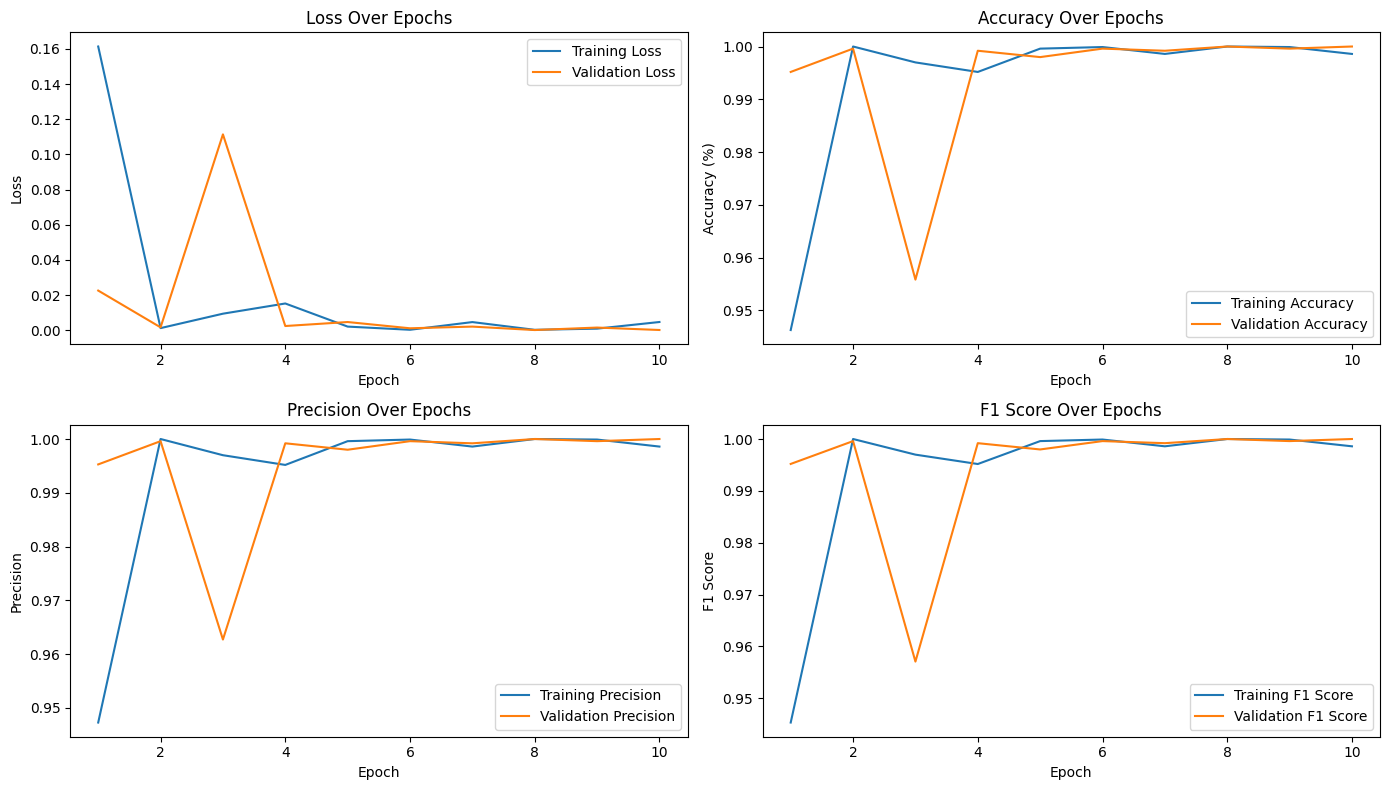

In [ ]:
epochs = np.arange(1, num_epochs + 1)

# Plot Loss
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()

# Plot Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, train_precisions, label='Training Precision')
plt.plot(epochs, val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision Over Epochs')
plt.legend()

# Plot F1 Score
plt.subplot(2, 2, 4)
plt.plot(epochs, train_f1s, label='Training F1 Score')
plt.plot(epochs, val_f1s, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()